In [4]:
!pip install -qr requirements.txt

In [ ]:
!pip install --upgrade jax jaxlib==0.1.69+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 196.5 MB 45 kB/s 
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.1.71+cuda111
    Uninstalling jaxlib-0.1.71+cuda111:
      Successfully uninstalled jaxlib-0.1.71+cuda111


In [5]:
model_name = 'ViT-B_32'  #["ViT-B_16","ViT-B_32", "ViT-L_16", "ViT-L_32"]
![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
    

Copying gs://vit_models/imagenet21k/ViT-B_32.npz...
| [1 files][400.0 MiB/400.0 MiB]                                                
Operation completed over 1 objects/400.0 MiB.                                    


In [6]:
import os
assert os.path.exists(f'{model_name}.npz')
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
jax.local_devices()

INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


[GpuDevice(id=0, process_index=0)]

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  cifar10_corrupted=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
  mnist=("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

In [9]:
from typing import Any, Dict, Iterable, Tuple, Union

import ml_collections

def get_config():
  """Returns config values other than model parameters."""

  config = ml_collections.ConfigDict()
  config.pretrained_dir = '.'
  config.dataset = ''
  config.tfds_manual_dir = None
  config.tfds_data_dir = None
  config.total_steps = None
  config.grad_norm_clip = 1.0
  config.optim_dtype = 'bfloat16'
  config.accum_steps = 8
  config.batch = 512
  config.batch_eval = 512
  config.shuffle_buffer = 50_000
  config.eval_every = 100
  config.progress_every = 10
  config.checkpoint_every = 1_000
  config.prefetch = 2
  config.base_lr = 0.03
  config.decay_type = 'cosine'
  config.warmup_steps = 500
  config.trainer = 'train'
  config.model = None
  config.model_or_filename = None
  config.dataset = None
  config.pp = None

  return config.lock()

In [10]:
DATASET_PRESETS = {
    'cifar10': ml_collections.ConfigDict(
        {'total_steps': 10_000,
         'pp': ml_collections.ConfigDict(
             {'train': 'train[:98%]',
              'test': 'test',
              'crop': 384})
         }),
    'cifar100': ml_collections.ConfigDict(
        {'total_steps': 10_000,
         'pp': ml_collections.ConfigDict(
             {'train': 'train[:98%]',
              'test': 'test',
              'crop': 384})
         }),
    'imagenet2012': ml_collections.ConfigDict(
        {'total_steps': 20_000,
         'pp': ml_collections.ConfigDict(
             {'train': 'train[:99%]',
              'test': 'validation',
              'crop': 384})
         }),
    'cifar10_corrupted/brightness_2': ml_collections.ConfigDict(
        {'total_steps': 10_000,
         'pp': ml_collections.ConfigDict(
             {
              'test': 'test',
              'crop': 384})
         }),
    'cifar10_corrupted/frosted_glass_blur_1': ml_collections.ConfigDict(
        {'total_steps': 10_000,
         'pp': ml_collections.ConfigDict(
             {
              'test': 'test',
              'crop': 384})
         }),
    'cifar10_corrupted/impulse_noise_5': ml_collections.ConfigDict(
        {'total_steps': 10_000,
         'pp': ml_collections.ConfigDict(
             {
              'test': 'test',
              'crop': 384})
         }),
    'cifar10_corrupted/gaussian_noise_3': ml_collections.ConfigDict(
        {'total_steps': 10_000,
         'pp': ml_collections.ConfigDict(
             {
              'test': 'test',
              'crop': 384})
         }),
    'cifar10_corrupted/shot_noise_5': ml_collections.ConfigDict(
        {'total_steps': 10_000,
         'pp': ml_collections.ConfigDict(
             {
              'test': 'test',
              'crop': 384})
         })
}

In [11]:
def config_with_dataset(config: ml_collections.ConfigDict,
                 dataset: str) -> ml_collections.ConfigDict:
  config = ml_collections.ConfigDict(config.to_dict())
  config.dataset = dataset
  config.update(DATASET_PRESETS[dataset])
  return config

In [12]:
# This method implements the different augmentation techniques. Uncomment the techniques you would want to apply and comment the ones you wish to avoid.
def get_data(*, data, mode, num_classes, image_decoder, repeats, batch_size, image_size, shuffle_buffer, preprocess=None, augment=False):
  
  def _process(data):
    im = image_decoder(data['image'])
    if im.shape[-1] == 1:
      im = tf.repeat(im, 3, axis=-1)
    if mode == 'train':
      channels = im.shape[-1]
      begin, size, _ = tf.image.sample_distorted_bounding_box(
          tf.shape(im),
          tf.zeros([0, 0, 4], tf.float32),
          area_range=(0.05, 1.0),
          min_object_covered=0, 
          use_image_if_no_bounding_boxes=True)
      im = tf.slice(im, begin, size)
      im.set_shape([None, None, channels])
      im = tf.image.resize(im, [image_size, image_size])
      if tf.random.uniform(shape=[]) > 0.5:
        im = tf.image.flip_left_right(im)
    else:
      im = tf.image.resize(im, [image_size, image_size])
    im = (im - 127.5) / 127.5
    label = tf.one_hot(data['label'], num_classes)
    return {'image': im, 'label': label}

  data = data.repeat(repeats)
  if mode == 'train':
    data = data.shuffle(shuffle_buffer)
  if preprocess is not None: 
    data = data.map(preprocess, tf.data.experimental.AUTOTUNE)
  data = data.map(_process, tf.data.experimental.AUTOTUNE)

  if augment:
    data_augmentation = tf.keras.Sequential([
       tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
       tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
       tf.keras.layers.GaussianNoise(stddev=0.5),
       tf.keras.layers.RandomContrast(factor=1.0)                                     
    ])

    flip_augmentation = tf.keras.Sequential([
       tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')
    ])
    rotation_augmentation = tf.keras.Sequential([
       tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    gaussian_augmentation = tf.keras.Sequential([
       tf.keras.layers.GaussianNoise(stddev=0.5)
    ])
    contrast_augmentation = tf.keras.Sequential([
       tf.keras.layers.RandomContrast(factor=1.0)
    ])

    # Uncomment the augmentation techniques that you would like to use
    flip_augmented_data = data.map(lambda x: {'image': flip_augmentation(x['image']), 'label': x['label']})
    rotation_augmented_data = data.map(lambda x: {'image': rotation_augmentation(x['image']), 'label': x['label']})
    gaussian_augmented_data = data.map(lambda x: {'image': gaussian_augmentation(x['image']), 'label': x['label']})
    contrast_augmented_data = data.map(lambda x: {'image': contrast_augmentation(x['image']), 'label': x['label']})
    augmented_data = data.map(lambda x: {'image': data_augmentation(x['image']), 'label': x['label']})

    # Uncomment the augmentation techniques that you would like to use
    data = data.concatenate(flip_augmented_data.repeat(1))
    data = data.concatenate(rotation_augmented_data.repeat(1))
    data = data.concatenate(gaussian_augmented_data.repeat(1))
    data = data.concatenate(contrast_augmented_data.repeat(1))
    data = data.concatenate(augmented_data.repeat(1))
    data = data.repeat(2)
  
  data = data.batch(batch_size, drop_remainder=True)
  num_devices = jax.local_device_count()

  def _shard(data):
    data['image'] = tf.reshape(data['image'],
                               [num_devices, -1, image_size, image_size, 3])
    data['label'] = tf.reshape(data['label'],
                               [num_devices, -1, num_classes])
    return data

  if num_devices is not None:
    data = data.map(_shard, tf.data.experimental.AUTOTUNE)

  return data.prefetch(1)



In [13]:
def get_tfds_info(dataset, split):
  data_builder = tfds.builder(dataset)
  return dict(
      num_examples=data_builder.info.splits[split].num_examples,
      num_classes=data_builder.info.features['label'].num_classes,
      int2str=data_builder.info.features['label'].int2str,
      examples_glob=None,
  )

def get_data_from_tfds(*, config, mode):
  data_builder = tfds.builder(config.dataset, data_dir=config.tfds_data_dir)
  data_builder.download_and_prepare(
      download_config=tfds.download.DownloadConfig(
          manual_dir=config.tfds_manual_dir))
  data = data_builder.as_dataset(
      split=config.pp[mode],
      # Reduces memory footprint in shuffle buffer.
      decoders={'image': tfds.decode.SkipDecoding()},
      shuffle_files=mode == 'train')
  image_decoder = data_builder.info.features['image'].decode_example
  dataset_info = get_tfds_info(config.dataset, config.pp[mode])

  augment = config.augment if config.augment else False

  return get_data(data=data, mode=mode, num_classes=dataset_info['num_classes'],
                  image_decoder=image_decoder, repeats=1, batch_size=config.batch_eval if mode == 'test' else config.batch,
                  image_size=config.pp['crop'], shuffle_buffer=min(dataset_info['num_examples'], config.shuffle_buffer),
                  augment=augment)



In [14]:
train_dataset = 'cifar10'
test_dataset = 'cifar10'
test_dataset_1 = 'cifar10_corrupted/brightness_2'
test_dataset_2 = 'cifar10_corrupted/frosted_glass_blur_1'
test_dataset_3 = 'cifar10_corrupted/impulse_noise_5'
test_dataset_4 = 'cifar10_corrupted/gaussian_noise_3'
test_dataset_5 = 'cifar10_corrupted/shot_noise_5'

batch_size = 512
train_config = config_with_dataset(get_config(), train_dataset)
test_config = config_with_dataset(get_config(), test_dataset)
test_config_1 = config_with_dataset(get_config(), test_dataset_1)
test_config_2 = config_with_dataset(get_config(), test_dataset_2)
test_config_3 = config_with_dataset(get_config(), test_dataset_3)
test_config_4 = config_with_dataset(get_config(), test_dataset_4)
test_config_5 = config_with_dataset(get_config(), test_dataset_5)

# num_classes = input_pipeline.get_dataset_info(test_dataset, 'test')['num_classes']
train_config.batch = batch_size
test_config.batch = batch_size
test_config_1.batch = batch_size
test_config_2.batch = batch_size
test_config_3.batch = batch_size
test_config_4.batch = batch_size
test_config_5.batch = batch_size

train_config.batch_eval = batch_size
test_config.batch_eval = batch_size
test_config_1.batch_eval = batch_size
test_config_2.batch_eval = batch_size
test_config_3.batch_eval = batch_size
test_config_4.batch_eval = batch_size
test_config_5.batch_eval = batch_size

train_config.pp.crop = 224
test_config.pp.crop = 224
test_config_1.pp.crop = 224
test_config_2.pp.crop = 224
test_config_3.pp.crop = 224
test_config_4.pp.crop = 224
test_config_5.pp.crop = 224

train_config.augment=True
test_config.augment=False
test_config_1.augment=False
test_config_2.augment=False
test_config_3.augment=False
test_config_4.augment=False
test_config_5.augment=False

In [15]:
ds_train = get_data_from_tfds(config=train_config, mode='train')
ds_test = get_data_from_tfds(config=test_config, mode='test')
ds_test_1 = get_data_from_tfds(config=test_config_1, mode='test')
ds_test_2 = get_data_from_tfds(config=test_config_2, mode='test')
ds_test_3 = get_data_from_tfds(config=test_config_3, mode='test')
ds_test_4 = get_data_from_tfds(config=test_config_4, mode='test')
ds_test_5 = get_data_from_tfds(config=test_config_5, mode='test')

del train_config, test_config, test_config_1, test_config_2, test_config_3, test_config_4, test_config_5

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmpr5qu7s_otfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.1f85bbcd74c14e949c5f7356768728c3...
INFO:absl:Generating split train


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete4UCLBU/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/cifar10/3.0.2.incomplete4UCLBU/cifar10-train.tfrecord. Shard lengths: [50000]
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete4UCLBU/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/cifar10/3.0.2.incomplete4UCLBU/cifar10-test.tfrecord. Shard lengths: [10000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split train[:98%], from /root/tensorflow_datasets/cifar10/3.0.2


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10_corrupted/brightness_2/1.0.0
INFO:absl:Load dataset info from /tmp/tmpzvz_eszltfds
INFO:absl:Field info.description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10_

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://zenodo.org/record/2535967/files/CIFAR-10-C.tar into /root/tensorflow_datasets/downloads/zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar.tmp.eda325c6566f4fecaef0f23c427ca574...
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10_corrupted/brightness_2/1.0.0.incompleteNFZZR2/cifar10_corrupted-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/cifar10_corrupted/brightness_2/1.0.0.incompleteNFZZR2/cifar10_corrupted-test.tfrecord. Shard lengths: [10000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/cifar10_corrupted/brightness_2/1.0.0


Dataset cifar10_corrupted downloaded and prepared to /root/tensorflow_datasets/cifar10_corrupted/brightness_2/1.0.0. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10_corrupted/brightness_2/1.0.0
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10_corrupted/frosted_glass_blur_1/1.0.0
INFO:absl:Load dataset info from /tmp/tmp77qaruiltfds
INFO:absl:Field info.description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10_corrupted (/root/tensorflow_datasets/cifar10_corrupted/frosted_glass_blur_1/1.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:URL https://zenodo.org/record/2535967/files/CIFAR-10-C.tar already downloaded: reusing /root/tensorflow_datasets/downloads/zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar.
INFO:absl:Reusing extraction of /root/tensorflow_datasets/downloads/zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar at /root/tensorflow_datasets/downloads/extracted/TAR.zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar.
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10_corrupted/frosted_glass_blur_1/1.0.0.incompleteJFZ5Q7/cifar10_corrupted-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/cifar10_corrupted/frosted_glass_blur_1/1.0.0.incompleteJFZ5Q7/cifar10_corrupted-test.tfrecord. Shard lengths: [10000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/cifar10_corrupted/frosted_glass_blur_1/1.0.0


Dataset cifar10_corrupted downloaded and prepared to /root/tensorflow_datasets/cifar10_corrupted/frosted_glass_blur_1/1.0.0. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10_corrupted/frosted_glass_blur_1/1.0.0
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10_corrupted/impulse_noise_5/1.0.0
INFO:absl:Load dataset info from /tmp/tmpqhdmbig1tfds
INFO:absl:Field info.description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10_corrupted (/root/tensorflow_datasets/cifar10_corrupted/impulse_noise_5/1.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:URL https://zenodo.org/record/2535967/files/CIFAR-10-C.tar already downloaded: reusing /root/tensorflow_datasets/downloads/zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar.
INFO:absl:Reusing extraction of /root/tensorflow_datasets/downloads/zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar at /root/tensorflow_datasets/downloads/extracted/TAR.zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar.
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10_corrupted/impulse_noise_5/1.0.0.incompleteRF4SEQ/cifar10_corrupted-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/cifar10_corrupted/impulse_noise_5/1.0.0.incompleteRF4SEQ/cifar10_corrupted-test.tfrecord. Shard lengths: [10000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/cifar10_corrupted/impulse_noise_5/1.0.0


Dataset cifar10_corrupted downloaded and prepared to /root/tensorflow_datasets/cifar10_corrupted/impulse_noise_5/1.0.0. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10_corrupted/impulse_noise_5/1.0.0
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10_corrupted/gaussian_noise_3/1.0.0
INFO:absl:Load dataset info from /tmp/tmpzj41nkartfds
INFO:absl:Field info.description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10_corrupted (/root/tensorflow_datasets/cifar10_corrupted/gaussian_noise_3/1.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:URL https://zenodo.org/record/2535967/files/CIFAR-10-C.tar already downloaded: reusing /root/tensorflow_datasets/downloads/zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar.
INFO:absl:Reusing extraction of /root/tensorflow_datasets/downloads/zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar at /root/tensorflow_datasets/downloads/extracted/TAR.zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar.
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10_corrupted/gaussian_noise_3/1.0.0.incomplete1H0CRR/cifar10_corrupted-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/cifar10_corrupted/gaussian_noise_3/1.0.0.incomplete1H0CRR/cifar10_corrupted-test.tfrecord. Shard lengths: [10000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/cifar10_corrupted/gaussian_noise_3/1.0.0


Dataset cifar10_corrupted downloaded and prepared to /root/tensorflow_datasets/cifar10_corrupted/gaussian_noise_3/1.0.0. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10_corrupted/gaussian_noise_3/1.0.0
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10_corrupted/shot_noise_5/1.0.0
INFO:absl:Load dataset info from /tmp/tmpe48yaq3qtfds
INFO:absl:Field info.description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10_corrupted (/root/tensorflow_datasets/cifar10_corrupted/shot_noise_5/1.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:URL https://zenodo.org/record/2535967/files/CIFAR-10-C.tar already downloaded: reusing /root/tensorflow_datasets/downloads/zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar.
INFO:absl:Reusing extraction of /root/tensorflow_datasets/downloads/zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar at /root/tensorflow_datasets/downloads/extracted/TAR.zenodo.org_record_2535967_files_CIFAR-10-CveKhgQeNf_oTKyNwIP7FhVi7FuwhPwpc8i1I-znjKPA.tar.
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10_corrupted/shot_noise_5/1.0.0.incompleteYF07UN/cifar10_corrupted-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/cifar10_corrupted/shot_noise_5/1.0.0.incompleteYF07UN/cifar10_corrupted-test.tfrecord. Shard lengths: [10000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/cifar10_corrupted/shot_noise_5/1.0.0


Dataset cifar10_corrupted downloaded and prepared to /root/tensorflow_datasets/cifar10_corrupted/shot_noise_5/1.0.0. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10_corrupted/shot_noise_5/1.0.0


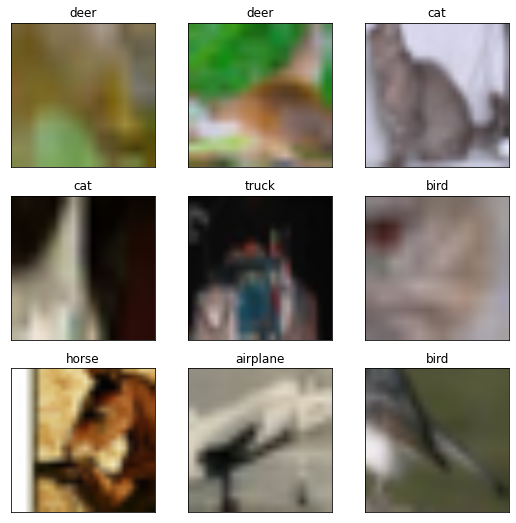

In [16]:
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(train_dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

In [17]:
MODEL_CONFIGS = {}

def _register(get_config):
  """Adds reference to model config into MODEL_CONFIGS."""
  config = get_config().lock()
  name = config.get('name')
  MODEL_CONFIGS[name] = config
  return get_config

@_register
def get_testing_config():
  """Returns a simple config used for testing."""
  config = ml_collections.ConfigDict()
  # Only used for testing.
  config.name = 'testing'
  config.patches = ml_collections.ConfigDict({'size': (16, 16)})
  config.hidden_size = 10
  config.transformer = ml_collections.ConfigDict()
  config.transformer.mlp_dim = 10
  config.transformer.num_heads = 2
  config.transformer.num_layers = 1
  config.transformer.attention_dropout_rate = 0.0
  config.transformer.dropout_rate = 0.1
  config.classifier = 'token'
  config.representation_size = None
  return config

@_register
def get_b16_config():
  """Returns the ViT-B/16 configuration."""
  config = ml_collections.ConfigDict()
  config.name = 'ViT-B_16'
  config.patches = ml_collections.ConfigDict({'size': (16, 16)})
  config.hidden_size = 768
  config.transformer = ml_collections.ConfigDict()
  config.transformer.mlp_dim = 3072
  config.transformer.num_heads = 12
  config.transformer.num_layers = 12
  config.transformer.attention_dropout_rate = 0.0
  config.transformer.dropout_rate = 0.0
  config.classifier = 'token'
  config.representation_size = None
  return config

@_register
def get_l16_config():
  """Returns the ViT-L/16 configuration."""
  config = ml_collections.ConfigDict()
  config.name = 'ViT-L_16'
  config.patches = ml_collections.ConfigDict({'size': (16, 16)})
  config.hidden_size = 1024
  config.transformer = ml_collections.ConfigDict()
  config.transformer.mlp_dim = 4096
  config.transformer.num_heads = 16
  config.transformer.num_layers = 24
  config.transformer.attention_dropout_rate = 0.0
  config.transformer.dropout_rate = 0.1
  config.classifier = 'token'
  config.representation_size = None
  return config

@_register
def get_b32_config():
  """Returns the ViT-B/32 configuration."""
  config = get_b16_config()
  config.name = 'ViT-B_32'
  config.patches.size = (32, 32)
  return config

@_register
def get_l32_config():
  """Returns the ViT-L/32 configuration."""
  config = get_l16_config()
  config.transformer.dropout_rate = 0.0
  config.name = 'ViT-L_32'
  config.patches.size = (32, 32)
  return config

In [18]:
import flax.linen as nn
import jax.numpy as jnp
from typing import Any, Callable, Optional, Tuple

Array = Any
PRNGKey = Any
Shape = Tuple[int]
Dtype = Any

In [19]:
import collections
import scipy
from  flax.training import checkpoints
from tensorflow.io import gfile

def recover_tree(keys, values):
  tree = {}
  sub_trees = collections.defaultdict(list)
  for k, v in zip(keys, values):
    if '/' not in k:
      tree[k] = v
    else:
      k_left, k_right = k.split('/', 1)
      sub_trees[k_left].append((k_right, v))
  for k, kv_pairs in sub_trees.items():
    k_subtree, v_subtree = zip(*kv_pairs)
    tree[k] = recover_tree(k_subtree, v_subtree)
  return tree


def load(path):
  with gfile.GFile(path, 'rb') as f:
    ckpt_dict = np.load(f, allow_pickle=False)
    keys, values = zip(*list(ckpt_dict.items()))
  params = checkpoints.convert_pre_linen(recover_tree(keys, values))
  if isinstance(params, flax.core.FrozenDict):
    params = params.unfreeze()
  return params

def _flatten_dict(d, parent_key='', sep='/'):
  items = []
  for k, v in d.items():
    path = parent_key + sep + k if parent_key else k
    if isinstance(v, collections.Mapping):
      items.extend(_flatten_dict(v, path, sep=sep).items())
    else:
      items.append((path, v))

  # Keeps the empty dict if it was set explicitly.
  if parent_key and not d:
    items.append((parent_key, {}))

  return dict(items)

def inspect_params(*,
                   params,
                   expected,
                   fail_if_extra=True,
                   fail_if_missing=True):
  params_flat = _flatten_dict(params)
  expected_flat = _flatten_dict(expected)
  missing_keys = expected_flat.keys() - params_flat.keys()
  extra_keys = params_flat.keys() - expected_flat.keys()

  # Adds back empty dict explicitly, to support layers without weights.
  # Context: FLAX ignores empty dict during serialization.
  empty_keys = set()
  for k in missing_keys:
    if isinstance(expected_flat[k], dict) and not expected_flat[k]:
      params[k] = {}
      empty_keys.add(k)
  missing_keys -= empty_keys

  if empty_keys:
    logging.warning('Inspect recovered empty keys:\n%s', empty_keys)
  if missing_keys:
    logging.info('Inspect missing keys:\n%s', missing_keys)
  if extra_keys:
    logging.info('Inspect extra keys:\n%s', extra_keys)

  if (missing_keys and fail_if_missing) or (extra_keys and fail_if_extra):
    raise ValueError(f'Missing params from checkpoint: {missing_keys}.\n'
                     f'Extra params in checkpoint: {extra_keys}.\n'
                     f'Restored params from checkpoint: {params_flat.keys()}.\n'
                     f'Expected params from code: {expected_flat.keys()}.')
  return params


def load_pretrained(*, pretrained_path, init_params, model_config):
  restored_params = inspect_params(
      params=load(pretrained_path),
      expected=init_params,
      fail_if_extra=False,
      fail_if_missing=False)

  # The following allows implementing fine-tuning head variants depending on the
  # value of `representation_size` in the fine-tuning job:
  # - `None` : drop the whole head and attach a nn.Linear.
  # - same number as in pre-training means : keep the head but reset the last
  #    layer (logits) for the new task.
  if model_config.get('representation_size') is None:
    if 'pre_logits' in restored_params:
      logging.info('load_pretrained: drop-head variant')
      restored_params['pre_logits'] = {}
  restored_params['head']['kernel'] = init_params['head']['kernel']
  restored_params['head']['bias'] = init_params['head']['bias']

  if 'posembed_input' in restored_params.get('Transformer', {}):
    # Rescale the grid of position embeddings. Param shape is (1,N,1024)
    posemb = restored_params['Transformer']['posembed_input']['pos_embedding']
    posemb_new = init_params['Transformer']['posembed_input']['pos_embedding']
    if posemb.shape != posemb_new.shape:
      logging.info('load_pretrained: resized variant: %s to %s', posemb.shape,
                   posemb_new.shape)
      ntok_new = posemb_new.shape[1]

      if model_config.classifier == 'token':
        posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
        ntok_new -= 1
      else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]

      gs_old = int(np.sqrt(len(posemb_grid)))
      gs_new = int(np.sqrt(ntok_new))
      logging.info('load_pretrained: grid-size from %s to %s', gs_old, gs_new)
      posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)

      zoom = (gs_new / gs_old, gs_new / gs_old, 1)
      posemb_grid = scipy.ndimage.zoom(posemb_grid, zoom, order=1)
      posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
      posemb = jnp.array(np.concatenate([posemb_tok, posemb_grid], axis=1))
      restored_params['Transformer']['posembed_input']['pos_embedding'] = posemb

  return flax.core.freeze(restored_params)

In [20]:
class MlpBlock(nn.Module):
  """Transformer MLP / feed-forward block."""

  mlp_dim: int
  dtype: Dtype = jnp.float32
  out_dim: Optional[int] = None
  dropout_rate: float = 0.1
  kernel_init: Callable[[PRNGKey, Shape, Dtype],
                        Array] = nn.initializers.xavier_uniform()
  bias_init: Callable[[PRNGKey, Shape, Dtype],
                      Array] = nn.initializers.normal(stddev=1e-6)

  @nn.compact
  def __call__(self, inputs, *, deterministic):
    """Applies Transformer MlpBlock module."""
    actual_out_dim = inputs.shape[-1] if self.out_dim is None else self.out_dim
    x = nn.Dense(
        features=self.mlp_dim,
        dtype=self.dtype,
        kernel_init=self.kernel_init,
        bias_init=self.bias_init)(  # pytype: disable=wrong-arg-types
            inputs)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=deterministic)
    output = nn.Dense(
        features=actual_out_dim,
        dtype=self.dtype,
        kernel_init=self.kernel_init,
        bias_init=self.bias_init)(  # pytype: disable=wrong-arg-types
            x)
    output = nn.Dropout(
        rate=self.dropout_rate)(
            output, deterministic=deterministic)
    return output

class Encoder1DBlock(nn.Module):
  """Transformer encoder layer.

  Attributes:
    inputs: input data.
    mlp_dim: dimension of the mlp on top of attention block.
    dtype: the dtype of the computation (default: float32).
    dropout_rate: dropout rate.
    attention_dropout_rate: dropout for attention heads.
    deterministic: bool, deterministic or not (to apply dropout).
    num_heads: Number of heads in nn.MultiHeadDotProductAttention
  """

  mlp_dim: int
  num_heads: int
  dtype: Dtype = jnp.float32
  dropout_rate: float = 0.1
  attention_dropout_rate: float = 0.1

  @nn.compact
  def __call__(self, inputs, *, deterministic):
    """Applies Encoder1DBlock module.

    Args:
      inputs: Inputs to the layer.
      deterministic: Dropout will not be applied when set to true.

    Returns:
      output after transformer encoder block.
    """

    # Attention block.
    assert inputs.ndim == 3, f'Expected (batch, seq, hidden) got {inputs.shape}'
    x = nn.LayerNorm(dtype=self.dtype)(inputs)
    x = nn.MultiHeadDotProductAttention(
        dtype=self.dtype,
        kernel_init=nn.initializers.xavier_uniform(),
        broadcast_dropout=False,
        deterministic=deterministic,
        dropout_rate=self.attention_dropout_rate,
        num_heads=self.num_heads)(
            x, x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=deterministic)
    x = x + inputs

    # MLP block.
    y = nn.LayerNorm(dtype=self.dtype)(x)
    y = MlpBlock(
        mlp_dim=self.mlp_dim, dtype=self.dtype, dropout_rate=self.dropout_rate)(
            y, deterministic=deterministic)

    return x + y

class IdentityLayer(nn.Module):
  """Identity layer, convenient for giving a name to an array."""

  @nn.compact
  def __call__(self, x):
    return x

class AddPositionEmbs(nn.Module):
  """Adds (optionally learned) positional embeddings to the inputs.

  Attributes:
    posemb_init: positional embedding initializer.
  """

  posemb_init: Callable[[PRNGKey, Shape, Dtype], Array]

  @nn.compact
  def __call__(self, inputs):
    """Applies AddPositionEmbs module.

    By default this layer uses a fixed sinusoidal embedding table. If a
    learned position embedding is desired, pass an initializer to
    posemb_init.

    Args:
      inputs: Inputs to the layer.

    Returns:
      Output tensor with shape `(bs, timesteps, in_dim)`.
    """
    # inputs.shape is (batch_size, seq_len, emb_dim).
    assert inputs.ndim == 3, ('Number of dimensions should be 3,'
                              ' but it is: %d' % inputs.ndim)
    pos_emb_shape = (1, inputs.shape[1], inputs.shape[2])
    pe = self.param('pos_embedding', self.posemb_init, pos_emb_shape)
    return inputs + pe

class Encoder(nn.Module):

  num_layers: int
  mlp_dim: int
  num_heads: int
  dropout_rate: float = 0.1
  attention_dropout_rate: float = 0.1

  @nn.compact
  def __call__(self, inputs, *, train):
    """Applies Transformer model on the inputs.

    Args:
      inputs: Inputs to the layer.
      train: Set to `True` when training.

    Returns:
      output of a transformer encoder.
    """
    assert inputs.ndim == 3  # (batch, len, emb)

    x = AddPositionEmbs(
        posemb_init=nn.initializers.normal(stddev=0.02),  # from BERT.
        name='posembed_input')(
            inputs)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not train)

    # Input Encoder
    for lyr in range(self.num_layers):
      x = Encoder1DBlock(
          mlp_dim=self.mlp_dim,
          dropout_rate=self.dropout_rate,
          attention_dropout_rate=self.attention_dropout_rate,
          name=f'encoderblock_{lyr}',
          num_heads=self.num_heads)(
              x, deterministic=not train)
    encoded = nn.LayerNorm(name='encoder_norm')(x)

    return encoded

class VisionTransformer(nn.Module):
  """VisionTransformer."""

  num_classes: int
  patches: Any
  transformer: Any
  hidden_size: int
  resnet: Optional[Any] = None
  representation_size: Optional[int] = None
  classifier: str = 'token'

  @nn.compact
  def __call__(self, inputs, *, train):

    x = inputs
    n, h, w, c = x.shape

    # We can merge s2d+emb into a single conv; it's the same.
    x = nn.Conv(
        features=self.hidden_size,
        kernel_size=self.patches.size,
        strides=self.patches.size,
        padding='VALID',
        name='embedding')(
            x)

    # Here, x is a grid of embeddings.

    # Transformer.
    n, h, w, c = x.shape
    x = jnp.reshape(x, [n, h * w, c])

    # If we want to add a class token, add it here.
    if self.classifier == 'token':
      cls = self.param('cls', nn.initializers.zeros, (1, 1, c))
      cls = jnp.tile(cls, [n, 1, 1])
      x = jnp.concatenate([cls, x], axis=1)

    x = Encoder(name='Transformer', **self.transformer)(x, train=train)

    if self.classifier == 'token':
      x = x[:, 0]
    elif self.classifier == 'gap':
      x = jnp.mean(x, axis=list(range(1, x.ndim - 1)))  # (1,) or (1,2)
    else:
      raise ValueError(f'Invalid classifier={self.classifier}')

    if self.representation_size is not None:
      x = nn.Dense(features=self.representation_size, name='pre_logits')(x)
      x = nn.tanh(x)
    else:
      x = IdentityLayer(name='pre_logits')(x)
    
    if self.num_classes:
      x = nn.Dense(
        features=self.num_classes,
        name='head',
        kernel_init=nn.initializers.zeros)(x)
    return x

In [21]:
# Utilities
def create_learning_rate_schedule(total_steps,
                                  base,
                                  decay_type,
                                  warmup_steps,
                                  linear_end=1e-5):

  def step_fn(step):
    """Step to learning rate function."""
    lr = base

    progress = (step - warmup_steps) / float(total_steps - warmup_steps)
    progress = jnp.clip(progress, 0.0, 1.0)
    if decay_type == 'linear':
      lr = linear_end + (lr - linear_end) * (1.0 - progress)
    elif decay_type == 'cosine':
      lr = lr * 0.5 * (1. + jnp.cos(jnp.pi * progress))
    else:
      raise ValueError(f'Unknown lr type {decay_type}')

    if warmup_steps:
      lr = lr * jnp.minimum(1., step / warmup_steps)

    return jnp.asarray(lr, dtype=jnp.float32)

  return step_fn

def accumulate_gradient(loss_and_grad_fn, params, images, labels, accum_steps):
  """Accumulate gradient over multiple steps to save on memory."""
  if accum_steps and accum_steps > 1:
    assert images.shape[0] % accum_steps == 0, (
        f'Bad accum_steps {accum_steps} for batch size {images.shape[0]}')
    step_size = images.shape[0] // accum_steps
    l, g = loss_and_grad_fn(params, images[:step_size], labels[:step_size])

    def acc_grad_and_loss(i, l_and_g):
      imgs = jax.lax.dynamic_slice(images, (i * step_size, 0, 0, 0),
                                   (step_size,) + images.shape[1:])
      lbls = jax.lax.dynamic_slice(labels, (i * step_size, 0),
                                   (step_size, labels.shape[1]))
      li, gi = loss_and_grad_fn(params, imgs, lbls)
      l, g = l_and_g
      return (l + li, jax.tree_multimap(lambda x, y: x + y, g, gi))

    l, g = jax.lax.fori_loop(1, accum_steps, acc_grad_and_loss, (l, g))
    return jax.tree_map(lambda x: x / accum_steps, (l, g))
  else:
    return loss_and_grad_fn(params, images, labels)

In [22]:
def make_update_fn(*, apply_fn, accum_steps, lr_fn):
  """Returns update step for data parallel training."""

  def update_fn(opt, step, batch, rng):

    _, new_rng = jax.random.split(rng)
    # Bind the rng key to the device id (which is unique across hosts)
    # Note: This is only used for multi-host training (i.e. multiple computers
    # each with multiple accelerators).
    dropout_rng = jax.random.fold_in(rng, jax.lax.axis_index('batch'))

    def cross_entropy_loss(*, logits, labels):
      logp = jax.nn.log_softmax(logits)
      return -jnp.mean(jnp.sum(logp * labels, axis=1))

    def loss_fn(params, images, labels):
      logits = apply_fn(
          dict(params=params),
          rngs=dict(dropout=dropout_rng),
          inputs=images,
          train=True)
      return cross_entropy_loss(logits=logits, labels=labels)

    l, g = accumulate_gradient(
        jax.value_and_grad(loss_fn), opt.target, batch['image'], batch['label'],
        accum_steps)
    g = jax.tree_map(lambda x: jax.lax.pmean(x, axis_name='batch'), g)
    l = jax.lax.pmean(l, axis_name='batch')

    opt = opt.apply_gradient(g, learning_rate=lr_fn(step))
    return opt, l, new_rng

  return jax.pmap(update_fn, axis_name='batch', donate_argnums=(0,))

In [23]:
class Optimizer(flax.optim.OptimizerDef):
  """Momentum optimizer that stores state using half-precision."""

  @flax.struct.dataclass
  class HyperParams:
    learning_rate: np.ndarray
    beta: np.ndarray
    grad_norm_clip: np.ndarray

  @flax.struct.dataclass
  class State:
    momentum: np.ndarray

  def __init__(self,
               learning_rate=None,
               beta=0.9,
               dtype='bfloat16',
               grad_norm_clip=None):
    hyper_params = Optimizer.HyperParams(learning_rate, beta, grad_norm_clip)
    super().__init__(hyper_params)
    self.dtype = dict(bfloat16=jnp.bfloat16, float32=jnp.float32)[dtype]

  def init_param_state(self, param):
    return Optimizer.State(jnp.zeros_like(param, dtype=self.dtype))

  def apply_gradient(self, hyper_params, params, state, grads):
    step = state.step
    params_flat, treedef = jax.tree_flatten(params)
    states_flat = treedef.flatten_up_to(state.param_states)
    grads_flat = treedef.flatten_up_to(grads)

    # Optionally resize the global gradient to a maximum norm.
    if hyper_params.grad_norm_clip:
      grads_l2 = jnp.sqrt(sum([jnp.vdot(p, p) for p in grads_flat]))
      grads_factor = jnp.minimum(1.0, hyper_params.grad_norm_clip / grads_l2)
      grads_flat = jax.tree_map(lambda param: grads_factor * param, grads_flat)

    out = [
        self.apply_param_gradient(step, hyper_params, param, state, grad)
        for param, state, grad in zip(params_flat, states_flat, grads_flat)
    ]

    new_params_flat, new_states_flat = list(zip(*out)) if out else ((), ())
    new_params = jax.tree_unflatten(treedef, new_params_flat)
    new_param_states = jax.tree_unflatten(treedef, new_states_flat)
    new_state = flax.optim.OptimizerState(step + 1, new_param_states)
    return new_params, new_state

  def apply_param_gradient(self, step, hyper_params, param, state, grad):
    del step
    assert hyper_params.learning_rate is not None, 'no learning rate provided.'
    momentum = state.momentum
    new_momentum = hyper_params.beta * momentum + grad
    new_param = param - hyper_params.learning_rate * new_momentum
    new_state = Optimizer.State(new_momentum.astype(self.dtype))
    return new_param, new_state

In [24]:
model_config = MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [25]:
num_classes = get_tfds_info(test_dataset, 'test')['num_classes']

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


In [26]:
model = VisionTransformer(num_classes=num_classes, **model_config)

variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='gpu')()

In [27]:
params = load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
INFO:absl:Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
INFO:absl:load_pretrained: drop-head variant


In [28]:
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (10,)
params_repl.cls: _ShardedDeviceArray (1, 10)


In [29]:
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [30]:
def get_accuracy(params_repl, test_set_name, test_set):
  good = total = 0
  steps = get_tfds_info(test_set_name, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), test_set.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [31]:
# Evaluate the performance on test data before fine-tuning
get_accuracy(params_repl, test_dataset, ds_test)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [01:13<00:00,  3.88s/it]


DeviceArray(0.10063734, dtype=float32)

In [32]:
total_steps = 100
warmup_steps = 20
decay_type = 'cosine'
grad_norm_clip = 1
accum_steps = 64
base_lr = 0.03

In [33]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

In [34]:
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 100/100 [27:22<00:00, 16.42s/it]


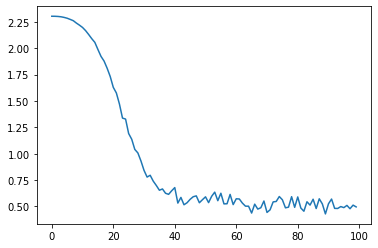

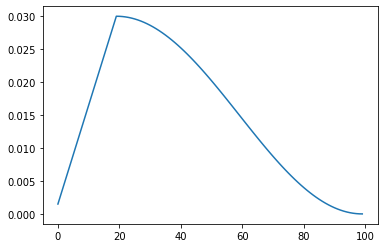

In [35]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [36]:
get_accuracy(opt_repl.target, test_dataset, ds_test)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:55<00:00,  2.90s/it]


DeviceArray(0.9770765, dtype=float32)

In [ ]:
get_accuracy(opt_repl.target, test_dataset_1, ds_test_1)

In [38]:
get_accuracy(opt_repl.target, test_dataset_2, ds_test_2)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10_corrupted/frosted_glass_blur_1/1.0.0
100%|██████████| 19/19 [00:55<00:00,  2.90s/it]


DeviceArray(0.84076893, dtype=float32)

In [39]:
get_accuracy(opt_repl.target, test_dataset_3, ds_test_3)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10_corrupted/impulse_noise_5/1.0.0
100%|██████████| 19/19 [00:55<00:00,  2.91s/it]


DeviceArray(0.5878906, dtype=float32)

In [40]:
get_accuracy(opt_repl.target, test_dataset_4, ds_test_4)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10_corrupted/gaussian_noise_3/1.0.0
100%|██████████| 19/19 [00:55<00:00,  2.91s/it]


DeviceArray(0.8127056, dtype=float32)

In [41]:
get_accuracy(opt_repl.target, test_dataset_5, ds_test_5)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10_corrupted/shot_noise_5/1.0.0
100%|██████████| 19/19 [00:55<00:00,  2.91s/it]


DeviceArray(0.74619657, dtype=float32)